In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Bidirectional,Dropout
from tensorflow.keras import regularizers
import keras
import matplotlib
%matplotlib inline

## Regreesion median notebook
- Take the median of all model prediction for all the health units in Canada
- Calculate the train and test rmse
- plot the test dataset for the QC province

In [149]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
## preprocess lost date
df_proc = pd_merge_new.loc[(pd_merge_new['HR_UID']=='6001') & (pd_merge_new['report_date']=='2020-08-08')]
df = pd.concat([df_proc]*2, ignore_index=True) # Ignores the index
df.iloc[1,4] = '2020-08-09'
pd_merge_new = pd.concat([pd_merge_new,df])
pd_merge_new.drop_duplicates(inplace = True) 
pd_merge_new = pd_merge_new.sort_values(by=['HR_UID','DATE'])
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
    lst.remove(label)
    data = pd_merge_new[lst]

    data1 = pd_merge_new[[label]]
    data_scale = scaler.fit_transform(data)
    data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
    df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_new.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_data_scale1.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_new[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_data_scale1], axis=1)
    return df_merge_model

df_merge_model = label('cumulative_deaths')
df_merge_model.drop(['index'], axis=1, inplace=True)
df_merge_model.reset_index(inplace=True)
df_merge_model.loc[df_merge_model['index']==22247,'report_date']='2020-08-09'
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index health_region PRUID_x                            HR_NAME PRUID_y  \
0      0       eastern      10  Eastern Regional Health Authority      10   
1      1       eastern      10  Eastern Regional Health Authority      10   
2      2       eastern      10  Eastern Regional Health Authority      10   
3      3       eastern      10  Eastern Regional Health Authority      10   
4      4       eastern      10  Eastern Regional Health Authority      10   

  report_date  Perceived_health_good  Perceived_health_poor HR_UID  \
0  2020-01-25                  0.615                  0.122   1011   
1  2020-01-26                  0.615                  0.122   1011   
2  2020-01-27                  0.615                  0.122   1011   
3  2020-01-28                  0.615                  0.122   1011   
4  2020-01-29                  0.615                  0.122   1011   

         DATE  ...     Mr_MP      M_MP  cases  cumulative_cases  deaths  \
0  2020-01-25  ...  0.757912  0.317417    0.0               0.0     0.0   
1  2020-01-26  ...  0.757712  0.258284    0.0               0.0     0.0   
2  2020-01-27  ...  0.757513  0.283201    0.0               0.0     0.0   
3  2020-01-28  ...  0.757306  0.308201    0.0               0.0     0.0   
4  2020-01-29  ...  0.757106  0.317818    0.0               0.0     0.0   

   Population_density  ambulatory  hospitals  nursing_residential  \
0            0.003738    0.072165   0.218487             0.100313   
1            0.003738    0.072165   0.218487             0.100313   
2            0.003738    0.072165   0.218487             0.100313   
3            0.003738    0.072165   0.218487             0.100313   
4            0.003738    0.072165   0.218487             0.100313   

   cumulative_deaths  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 52 columns]

In [157]:
## Run
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID', 'report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new


def shift_label(label, ahead_date):
    col_name = str('la-'+label)
    df_new2[col_name] = df_new2.groupby(['HR_UID'])[label].shift(ahead_date)
    return df_new2

df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
# remove null row
df_new1.dropna(inplace=True)
# drop duplicated columns
df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]
# ## preprocess lost date
# df_proc = df_new2.loc[(df_new2['HR_UID']=='6001') & (df_new2['report_date']=='2020-08-08 00:00:00')]
# df = pd.concat([df_proc]*2, ignore_index=True) # Ignores the index
# df.iloc[1,1] = pd.Timestamp('2020-08-09')
# df_new2 = pd.concat([df_new2,df])
# df_new2.drop_duplicates(inplace = True) 

def pred_preiod(predtime):
    if predtime=='5daypred':
        df_new3 = shift_label('cumulative_deaths',5)
        # remove null row
        df_new3.dropna(inplace=True)
        # drop duplicated columns
        df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]

        ## Merge df back with health indicator
        df_new5 = pd.merge(df_merge_model, df_new4, how='left', on=['HR_UID','report_date'])
        # remove null row
        df_new5.dropna(inplace=True)
        # drop duplicated columns
        df_new6 = df_new5.loc[:,~df_new5.columns.duplicated()]
        # df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]
        df_dum_HR = pd.get_dummies(df_new6.HR_UID, prefix='HR_UID')
        df_hr_dum = pd.concat([df_new6, df_dum_HR], axis=1)
    elif predtime=='1daypred':
        ## Merge df back with health indicator
        df_new3 = pd.merge(df_merge_model, df_new2, how='left', on=['HR_UID','report_date'])
        # remove null row
        df_new3.dropna(inplace=True)
        # drop duplicated columns
        df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]
        # df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]
        df_dum_HR = pd.get_dummies(df_new4.HR_UID, prefix='HR_UID')
        df_hr_dum = pd.concat([df_new4, df_dum_HR], axis=1)

    return df_hr_dum,df_dum_HR

df_hr_dum,df_dum_HR = pred_preiod('1daypred')
# select one hr
def df_filter(hr, case, lag_date, predtime):
    df_hr = df_hr_dum.loc[df_hr_dum['HR_UID']==str(hr)]
    df_train = df_hr.loc[(df_hr['report_date'] >= df_hr['report_date'].min()) & (df_hr['report_date'] < '2020-07-01')]
    df_eval = df_hr.loc[(df_hr['report_date'] >= '2020-07-01') & (df_hr['report_date'] <= df_hr['report_date'].max())]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP_x', 'Mt_MP_x', 'Mw_MD_x', 'Mgp_RP_x', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    col_lst+=df_dum_HR.columns.tolist()
    
    if case:
        col_lst.append('cases_x')
    if predtime=='5daypred':
        label = 'la-cumulative_deaths'
    elif predtime=='1daypred':
        label = 'cumulative_deaths_x'
    # train set
    df_feature_train = df_train[col_lst]
    df_label_train = df_train[[label]]
    # eval set
    df_feature_val = df_eval[col_lst]
    df_label_val = df_eval[[label]]
    # drop duplicated columns
    df_hr1 = df_hr.loc[:,~df_hr.columns.duplicated()]
    return df_feature_train, df_label_train, df_feature_val, df_label_val, df_hr1



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [8]:
df_hr_dum.columns.tolist()

['index',
 'health_region',
 'PRUID_x',
 'HR_NAME',
 'PRUID_y',
 'report_date',
 'Perceived_health_good',
 'Perceived_health_poor',
 'HR_UID',
 'DATE',
 'PROV',
 'Md_PD',
 'Mrr_PD',
 'Mgp_PD',
 'Mp_PD',
 'Mt_PD',
 'Mw_PD',
 'Mr_PD',
 'M_PD',
 'Md_MD',
 'Mrr_MD',
 'Mgp_MD',
 'Mp_MD',
 'Mt_MD',
 'Mw_MD_x',
 'Mr_MD',
 'M_MD',
 'Md_RP',
 'Mrr_RP',
 'Mgp_RP_x',
 'Mp_RP',
 'Mt_RP_x',
 'Mw_RP',
 'Mr_RP',
 'M_RP',
 'Md_MP',
 'Mrr_MP',
 'Mgp_MP',
 'Mp_MP',
 'Mt_MP_x',
 'Mw_MP',
 'Mr_MP',
 'M_MP',
 'cases_x',
 'cumulative_cases_x',
 'deaths_x',
 'Population_density',
 'ambulatory',
 'hospitals',
 'nursing_residential',
 'cumulative_deaths_x',
 'cumulative_deaths_y',
 'cumulative_cases_y',
 'cases_y',
 'deaths_y',
 'Mt_RP_y',
 'Mt_MP_y',
 'Mw_MD_y',
 'Mgp_RP_y',
 'HR_UID_-1',
 'cumulative_deaths_-1',
 'cumulative_cases_-1',
 'cases_-1',
 'deaths_-1',
 'Mt_RP_-1',
 'Mt_MP_-1',
 'Mw_MD_-1',
 'Mgp_RP_-1',
 'HR_UID_-2',
 'cumulative_deaths_-2',
 'cumulative_cases_-2',
 'cases_-2',
 'deaths_-2',
 'Mt_

In [158]:
## Run
# split_sequences to change the dimensions of input
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []
X_val_lst = []
y_val_lst = []

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, label_seq):
    label_seq = label_seq.reshape(label_seq.shape[0], -1)
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], label_seq[end_ix-1, :]
#         seq_x = sequences[i:end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y).reshape(-1)

for hr in df_hr_dum['HR_UID'].unique().tolist():
    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'1daypred')
    
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
  
    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)

    
X_train = np.concatenate(X_train_lst, axis=0)
# X_train.shape (4182, 2, 101)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
# Y_train.shape (4182,)
y_test = np.concatenate(y_test_lst, axis=0)

Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
# Y_val = y_val.reshape(-1,)
Y_train.shape

(16906,)

In [159]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(16906, 1, 158)

In [12]:
model_1 = keras.models.load_model("Classify_update/reg_model/Reg_0.05_LR_0.001/mdel602_1d_reg")
model_2 = keras.models.load_model("Classify_update/reg_model/Reg_0.1_LR_0.001/mdel602_1d_reg")
model_3 = keras.models.load_model("Classify_update/reg_model/Reg_0.1_LR_0.005/mdel602_1d_reg")
model_4 = keras.models.load_model("Classify_update/reg_model/Reg_0.5_LR_0.001/mdel602_1d_reg")
model_5 = keras.models.load_model("Classify_update/reg_model/Reg_0.5_LR_0.005/mdel602_1d_reg")


In [162]:
arr = np.array([])
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []
for hr in df_hr_dum['HR_UID'].unique().tolist():
    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'1daypred')
    
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
  
    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    pred_1 = np.array(model_1.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_2 = np.array(model_2.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_3 = np.array(model_3.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_4 = np.array(model_4.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_5 = np.array(model_5.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_test_1 = np.array(model_1.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_2 = np.array(model_2.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_3 = np.array(model_3.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_4 = np.array(model_4.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_5 = np.array(model_5.predict(X_test_3d).flatten()).reshape(-1,47)
    
    arr_1 = np.append(pred_1, pred_2, axis=0)
    arr_2 = np.append(arr_1, pred_3, axis=0)
    arr_3 = np.append(arr_2, pred_4, axis=0)
    arr_4 = np.append(arr_3, pred_5, axis=0)
    arr_median = np.median(arr_4, axis = 0)
    
    arr_1 = np.append(pred_test_1, pred_test_2, axis=0)
    arr_2 = np.append(arr_1, pred_test_3, axis=0)
    arr_3 = np.append(arr_2, pred_test_4, axis=0)
    arr_4 = np.append(arr_3, pred_test_5, axis=0)
    arr_median_test = np.median(arr_4, axis = 0)
    
    X_train_lst.append(arr_median)
    y_train_lst.append(y_train)
    X_test_lst.append(arr_median_test)
    y_test_lst.append(y_test)
    
    
    
X_train = np.concatenate(X_train_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
X_test = np.concatenate(X_test_lst, axis=0)
y_test = np.concatenate(y_test_lst, axis=0)
Y_train = y_train.reshape(-1,)  
Y_test = y_test.reshape(-1,)  
Y_train.shape

(16906,)

In [164]:
train_rmse = mean_squared_error(Y_train, X_train, squared=False)
test_rmse = mean_squared_error(Y_test, X_test, squared=False)
print('train rmse:', train_rmse)
print('test rmse:', test_rmse)

train rmse: 0.003366580582364642
test rmse: 0.0066457536188170695


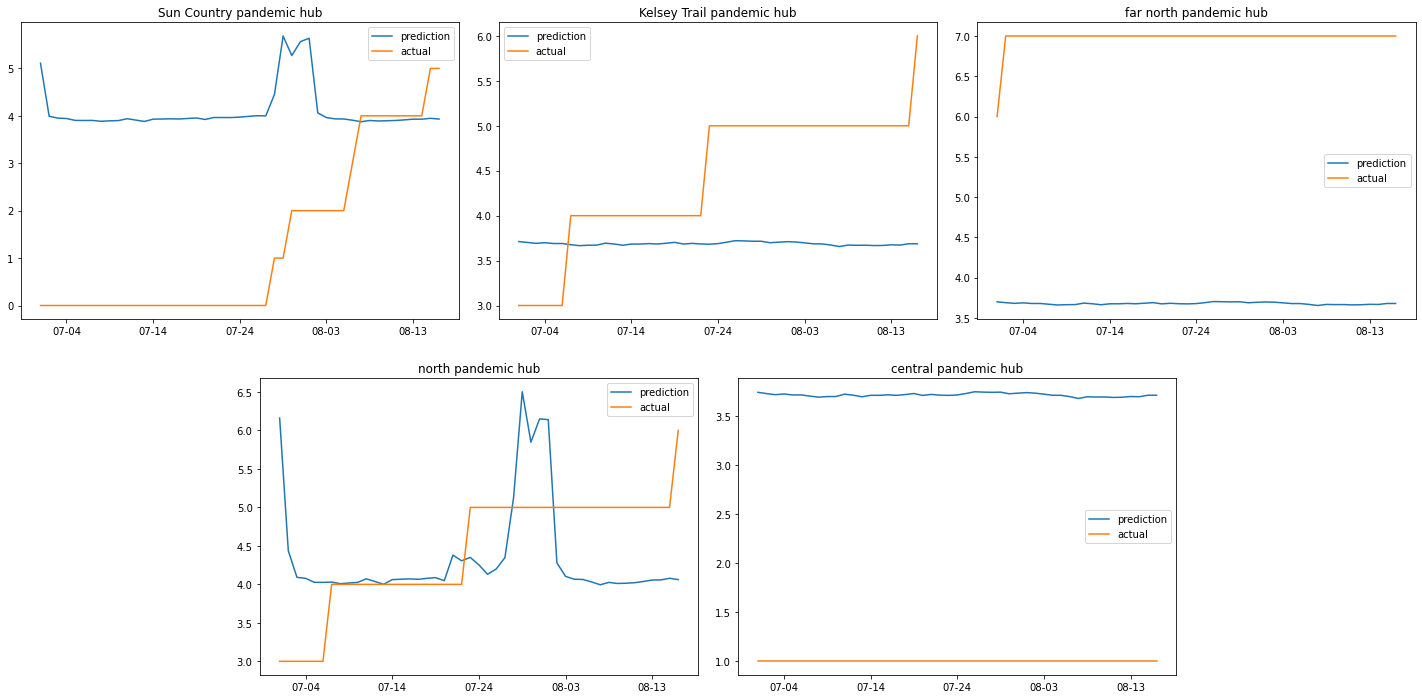

In [166]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'1daypred')
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val


    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    pred_1 = np.array(model_1.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_2 = np.array(model_2.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_3 = np.array(model_3.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_4 = np.array(model_4.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_5 = np.array(model_5.predict(X_train_3d).flatten()).reshape(-1,158)
    pred_test_1 = np.array(model_1.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_2 = np.array(model_2.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_3 = np.array(model_3.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_4 = np.array(model_4.predict(X_test_3d).flatten()).reshape(-1,47)
    pred_test_5 = np.array(model_5.predict(X_test_3d).flatten()).reshape(-1,47)
    
    arr_1 = np.append(pred_1, pred_2, axis=0)
    arr_2 = np.append(arr_1, pred_3, axis=0)
    arr_3 = np.append(arr_2, pred_4, axis=0)
    arr_4 = np.append(arr_3, pred_5, axis=0)
    arr_median = np.median(arr_4, axis = 0)
    
    arr_1 = np.append(pred_test_1, pred_test_2, axis=0)
    arr_2 = np.append(arr_1, pred_test_3, axis=0)
    arr_3 = np.append(arr_2, pred_test_4, axis=0)
    arr_4 = np.append(arr_3, pred_test_5, axis=0)
    arr_median_test = np.median(arr_4, axis = 0)
    
    arr_median_test = arr_median_test.reshape(-1, 1)
    
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))
    
    y_test = y_test.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(arr_median_test)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('4701')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Sun Country pandemic hub')
plt.legend(['prediction', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4708')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Kelsey Trail pandemic hub')
plt.legend(['prediction', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4711')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('far north pandemic hub')
plt.legend(['prediction', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4709')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('north pandemic hub')
plt.legend(['prediction', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4707')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('central pandemic hub')
plt.legend(['prediction', 'actual'])

# 